In [ ]:
# This is the implementation of the EncDec-AD model based on the paper "LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection". And a slight variantion "TimeNet" based on the paper "TimeNet: Pre-trained deep recurrent neural network for time series classiﬁcation", which has been shown that achives better performance in the time series anomaly detection scenario. The only difference is the second model feeds constants to its decoder as input.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the EncDec-AD model

In [2]:
# decoder input: original time series value at last time step

class EncDecAD(object):
    def __init__(self,latent_dim,inputs,is_training=False):
        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.input_dim = inputs[0].get_shape().as_list()[1]
        self.is_training = is_training
        
        self.enc_cell = tf.nn.rnn_cell.LSTMCell(latent_dim)
        self.dec_cell = tf.nn.rnn_cell.LSTMCell(latent_dim)
        
        with tf.variable_scope('encoder'):
            self.enc_outputs, self.enc_state = tf.nn.static_rnn(self.enc_cell, inputs, 
                                                         dtype=tf.float32)
        with tf.variable_scope('decoder') as scope_dec:
            w = tf.Variable(tf.truncated_normal([latent_dim,self.input_dim],
                                               dtype=tf.float32),name="w")
            b = tf.Variable(tf.constant(0.1,shape=[self.input_dim],
                                               dtype=tf.float32),name="b")
            
            dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)]+inputs[::-1][:-1]
            dec_outputs, dec_state = tf.nn.static_rnn(self.dec_cell, dec_inputs,
                                                     initial_state=self.enc_state,
                                                     dtype=tf.float32)
            dec_outputs = dec_outputs[::-1]
            dec_output = tf.transpose(tf.stack(dec_outputs),[1,0,2])
            w = tf.tile(tf.expand_dims(w,0),[self.batch_num,1,1])
            self.output = tf.matmul(dec_output,w)+b
            
        #Calculate loss
        self.input = tf.transpose(tf.stack(inputs),[1,0,2])
        self.loss = tf.reduce_sum(tf.square(self.input - self.output))
        self.error_vec = tf.abs(tf.reshape((self.input - self.output),[-1]))

        #Optimization if is training
        if self.is_training == True:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

# Definition of the TimeNet model

In [ ]:
class TimeNet(object):
    def __init__(self,latent_dim,inputs,is_training=False):
        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.input_dim = inputs[0].get_shape().as_list()[1]
        
        self.enc_cell = tf.nn.rnn_cell.LSTMCell(latent_dim)
        self.dec_cell = tf.nn.rnn_cell.LSTMCell(latent_dim)
        
        with tf.variable_scope('encoder'):
            self.enc_outputs, self.enc_state = tf.nn.static_rnn(self.enc_cell, inputs, 
                                                         dtype=tf.float32)
        with tf.variable_scope('decoder') as scope_dec:
            w = tf.Variable(tf.truncated_normal([latent_dim,self.input_dim],
                                               dtype=tf.float32),name="w")
            b = tf.Variable(tf.constant(0.1,shape=[self.input_dim],
                                               dtype=tf.float32),name="b")
            
            dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)
                                  for _ in range(len(inputs))]
            dec_outputs, dec_state = tf.nn.static_rnn(self.dec_cell, dec_inputs,
                                                     initial_state=self.enc_state,
                                                     dtype=tf.float32)
            dec_outputs = dec_outputs[::-1]
            dec_output = tf.transpose(tf.stack(dec_outputs),[1,0,2])
            w = tf.tile(tf.expand_dims(w,0),[self.batch_num,1,1])
            self.output = tf.matmul(dec_output,w)+b
            
        #Calculate loss
        self.input = tf.transpose(tf.stack(inputs),[1,0,2])
        self.loss = tf.reduce_mean(tf.square(self.input - self.output))
        self.error_vec = tf.abs(tf.reshape((self.input - self.output),[-1]))
        #Optimization
        if self.is_training == True:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

# Experiments

## Load dataset

### 1. power demand dataset

In [3]:
# power demand dataset

%run Loaddata
from Loaddata import Loaddata

ld = Loaddata("power_demand")
datasets = ld.read()
[training_normal, validation_1, validation_2, test_normal, validation_anomaly, test_anomaly,whole_normal,whole_anormaly] = datasets

L = 84
NUM_LSTM_UNITS = 9

time_steps = L
latent_dim = NUM_LSTM_UNITS
n_epoch = 200
batch_size = 3
input_dim = 1

inputs_array = []
for dataset in datasets:

    # reshape the dataset to a list, each element with the shape [batch_size, time_steps, input_dim]
    size = dataset.shape[0]//time_steps//batch_size
    data_input = np.reshape(dataset[:size*batch_size*time_steps],(size,batch_size,time_steps,input_dim))
    array = [t for t in data_input]
    inputs_array.append(array)

# inputs placeholder
p_input = tf.placeholder(tf.float32, [batch_size, time_steps, input_dim])
p_inputs = [t for t in tf.split(p_input, time_steps, 1)]
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, time_steps, 1)]



C:\Users\Bin\Desktop\Thesis\code\Loaddata.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  sub_power = sub_power.reshape(-1, 1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### 2. space shuttle dataset

In [ ]:
# space shuttle dataset

%run Loaddata
from Loaddata import Loaddata

ld = Loaddata("space_shuttle")
dataset = ld.read()

SUB_SEQUENCE_LENGTH = 500 # 1500/3
time_steps = SUB_SEQUENCE_LENGTH
latent_dim = 50
n_epoch = 500
batch_size = 2
input_dim = 1

# reshape the dataset to a list, each element with the shape [batch_size, time_steps, input_dim]
size = dataset.shape[0]//time_steps//batch_size
data_input = np.reshape(dataset[:size*batch_size*time_steps],(size,batch_size,time_steps,input_dim))
array = [t for t in data_input]
#del dataset, data_input

# inputs placeholder
p_input = tf.placeholder(tf.float32, [batch_size, time_steps, input_dim])
p_inputs = [t for t in tf.split(p_input, time_steps, 1)]
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, time_steps, 1)]


### 3. ECG dataset

In [ ]:
# ECG dataset

%run Loaddata
from Loaddata import Loaddata

ld = Loaddata("ecg")
dataset = ld.read()

SUB_SEQUENCE_LENGTH = 208
time_steps = SUB_SEQUENCE_LENGTH
latent_dim = 1
n_epoch = 500
batch_size = 15
input_dim = 1

# reshape the dataset to a list, each element with the shape [batch_size, time_steps, input_dim]
size = dataset.shape[0]//time_steps//batch_size
data_input = np.reshape(dataset[:size*batch_size*time_steps],(size,batch_size,time_steps,input_dim))
array = [t for t in data_input]
#del dataset, data_input

# inputs placeholder
p_input = tf.placeholder(tf.float32, [batch_size, time_steps, input_dim])
p_inputs = [t for t in tf.split(p_input, time_steps, 1)]
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, time_steps, 1)]

## Training

In [6]:
# EncDec-AD model training
# inputs_array: [training_normal, validation_1, validation_2, test_normal, validation_anomaly, test_anomaly]

encdecad = EncDecAD(latent_dim, p_inputs,is_training=True)
saver = tf.train.Saver()
with tf.Session() as sess1:
    #saver.restore(sess, "/tmp/EncDecAD_model.ckpt")
    #print("Model restored.")
    sess1.run(tf.global_variables_initializer())
    for i in range(n_epoch):
        for a in inputs_array[6]:  #training all normal
            loss_val, _ = sess1.run([encdecad.loss,encdecad.train],{p_input:a})
        print("Epoch %d: " % (i+1),loss_val)
    save_path = saver.save(sess1, "C:/Users/Bin/Desktop/Thesis/code/tmp/EncDecAD_power_demand_200epochs_9unit_batchsize3.ckpt")
    print("Model saved in file: %s" % save_path) 
'''
    #example
    input_, output_, encoded_, enc_state = sess1.run([encdecad.input, encdecad.output, 
                                                    encdecad.enc_outputs, encdecad.enc_state], {p_input:array[-1]})
    embedding = enc_state[0]
    print("Example: ")
    print("embedding: ",embedding)
    print("input :", input_[0,:,:].flatten())
    print("output :", output_[0,:,:].flatten())
'''

Epoch 1:  34.6176
Epoch 2:  12.931
Epoch 3:  10.9281
Epoch 4:  10.7431
Epoch 5:  10.5483
Epoch 6:  10.1416
Epoch 7:  9.72997
Epoch 8:  9.48949
Epoch 9:  9.24032
Epoch 10:  8.99078
Epoch 11:  8.77225
Epoch 12:  8.58378
Epoch 13:  8.40277
Epoch 14:  8.22083
Epoch 15:  8.01995
Epoch 16:  7.79562
Epoch 17:  7.5492
Epoch 18:  7.27895
Epoch 19:  6.98732
Epoch 20:  6.68154
Epoch 21:  6.37191
Epoch 22:  6.06617
Epoch 23:  5.7674
Epoch 24:  5.48013
Epoch 25:  5.20962
Epoch 26:  4.95972
Epoch 27:  4.73223
Epoch 28:  4.52729
Epoch 29:  4.34413
Epoch 30:  4.18141
Epoch 31:  4.03738
Epoch 32:  3.91004
Epoch 33:  3.79736
Epoch 34:  3.69739
Epoch 35:  3.60837
Epoch 36:  3.52878
Epoch 37:  3.45733
Epoch 38:  3.39296
Epoch 39:  3.33481
Epoch 40:  3.28215
Epoch 41:  3.23441
Epoch 42:  3.19109
Epoch 43:  3.15176
Epoch 44:  3.11606
Epoch 45:  3.08367
Epoch 46:  3.05427
Epoch 47:  3.0276
Epoch 48:  3.0034
Epoch 49:  2.98142
Epoch 50:  2.96145
Epoch 51:  2.94328
Epoch 52:  2.92672
Epoch 53:  2.91159
Epoch 5

'\n    #example\n    input_, output_, encoded_, enc_state = sess1.run([encdecad.input, encdecad.output, \n                                                    encdecad.enc_outputs, encdecad.enc_state], {p_input:array[-1]})\n    embedding = enc_state[0]\n    print("Example: ")\n    print("embedding: ",embedding)\n    print("input :", input_[0,:,:].flatten())\n    print("output :", output_[0,:,:].flatten())\n'

In [4]:
# try

is_training = False
encdecad = EncDecAD(latent_dim, p_inputs,is_training)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "C:/Users/Bin/Desktop/Thesis/code/tmp/EncDecAD_power_demand_200epochs_9unit_batchsize3.ckpt")
    print("Model restored.")
    
    
    sess.run(tf.global_variables_initializer())
    test_error_vectors = []
    
    foo1 = []
    foo2 = []
    foo3 = []
    for a in inputs_array[7]: 
        error_vector,input_,output_ = sess.run([encdecad.error_vec,encdecad.input,encdecad.output],{p_input:a})
        foo1.append(error_vector)
        foo2.append(input_)
        foo3.append(output_)

    
    '''
    anomaly_scores = []
    for error_vec in test_error_vectors:
        error_vec = np.reshape(error_vec,error_mean.shape)
        tmp = np.dot( (error_vec - error_mean) ,error_variance.T )
        a_score =np.dot(tmp,(error_vec - error_mean).T)#**********
        anomaly_scores.append(a_score)
    '''

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/code/tmp/EncDecAD_power_demand_200epochs_9unit_batchsize3.ckpt
Model restored.


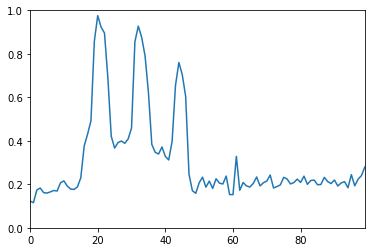

In [5]:
pd.Series(np.reshape(foo1,(-1)))[-100:].reset_index(drop=True).plot(ylim=[0,1]) #error

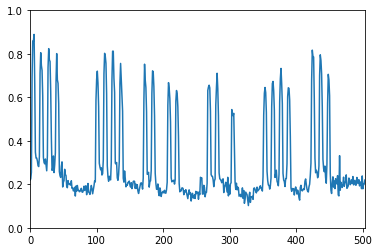

In [6]:
pd.Series(np.reshape(foo2,(-1)))[:].reset_index(drop=True).plot(ylim=[0,1.]) #input

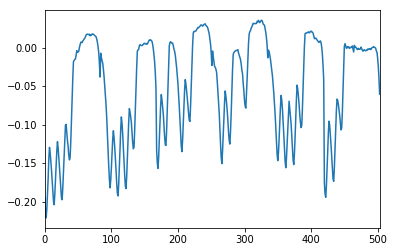

In [7]:
pd.Series(np.reshape(foo3,(-1)))[:].reset_index(drop=True).plot() #output

In [ ]:
# create an EncDecAD object

is_training = False
encdecad = EncDecAD(latent_dim, p_inputs,is_training)
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "C:/Users/Bin/Desktop/Thesis/code/tmp/EncDecAD_power_training_500epochs.ckpt")
    print("Model restored.")
    sess.run(tf.global_variables_initializer())
    validation1_error_vectors = []
    for a in inputs_array[1]:  #validation_1
        error_vector = sess.run([encdecad.error_vec],{p_input:a})[0]
        validation1_error_vectors.append(error_vector)

    # Use error vectors to estimate the parameters mu and sigma of a normal distribution using Maximum Likelihood Estimation
    error_ = []
    for i in range(len(validation1_error_vectors)):
        for j in range(len(validation1_error_vectors[0])):
            error_.append(validation1_error_vectors[i][j])
    error_ = np.reshape(np.array(error_),(int(validation_1.shape[0]/time_steps),time_steps))   # shape(9,84)

    error_mean = np.mean(error_,axis=0)
    error_variance = np.cov(error_.T)
    print("error_mean: ",error_mean)
    print("error_variance",error_variance)


    # EncDec-AD model test
    # calculate the anomaly score

    sess.run(tf.global_variables_initializer())
    test_error_vectors = []
    iii = []
    ooo = []
    for p in [2,3,4,5]:
        print(p)
        for a in inputs_array[p]:  #test_anomalous
            error_vector,_,_ = sess.run([encdecad.error_vec,encdecad.input,encdecad.output],{p_input:a})[0]
            foo = [error_vector[i] for i in range(error_vector.shape[0])]
            for f in foo:
                test_error_vectors.append(f)
          

        anomaly_scores = []
        for error_vec in test_error_vectors:
            error_vec = np.reshape(error_vec,error_mean.shape)
            tmp = np.dot( (error_vec - error_mean) ,error_variance.T )
            a_score =np.dot(tmp,(error_vec - error_mean).T)#**********
            anomaly_scores.append(a_score)
    pd.Series(np.reshape(ooo,(84*27))).plot()
    

In [ ]:
# TimeNet
timenet = TimeNet(latent_dim, p_inputs,is_training=True)
saver = tf.train.Saver()
with tf.Session() as sess:
    #saver.restore(sess, "C:/Users/Bin/Desktop/Thesis/code/tmp/TimeNet_power_demand_500epochs_40unit.ckpt")
    #print("Model restored.")
    sess.run(tf.global_variables_initializer())
    test_error_vectors = []
    
    foo1 = []
    foo2 = []
    foo3 = []
    for a in array: 
        error_vector,input_,output_ = sess.run([timenet.error_vec,timenet.input,timenet.output],{p_input:a})
        
        foo1.append(error_vector)
        foo2.append(input_)
        foo3.append(output_)
    save_path = saver.save(sess, "C:/Users/Bin/Desktop/Thesis/code/tmp/TimeNet_power_demand_500epochs_40unit.ckpt")
    print("Model saved in file: %s" % save_path) 